### Επίδραση του Ορίου Ρίπων στα Κέρδη και άλλες Μεταβλητές των Επιχειρήσεων

**Πείραμα:**
- Emission cap = 0-100%
- 9 εταιρείες
- 3 τομείς
  - Ο 3ος τομέας έχει **πολύ μεγάλο** μέγεθος σε όρους πωλήσεων


In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from funkwpap import *
import sympy as sp, pandas as pd, numpy as np, tqdm, time, sys, matplotlib.pyplot as plt, tqdm
from statistics import mean
from scipy.optimize import fsolve



In [2]:
x = sp.symbols('x')
cap = 2000 # total emission cap
Regulator26 = Regulator("test1", permit_price = 2.4079, emission_cap = cap)
sector1 = Sector('cement', price_demand_function= 100 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator26)
sector2 = Sector('steel', price_demand_function=150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator26)
sector3 = Sector('paper', price_demand_function= 200 - 0.02*x**1.5, free_emission_multiplier= 0, regulator= Regulator26)
country1 = Country('DE', 1, regulator= Regulator26)
country2 = Country('FI', 0.5, regulator= Regulator26)
country3 = Country('GR', size= 0.1, regulator= Regulator26)

# Create Firms using objects
firm1 = Firm('firm1', 1, 1, x*0, 2*x+ 2*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator26)
firm2 = Firm('firm2', 1, 2, x*0, 3*x+ 3*x**2 + 2*x**3, 0, 0, 0, regulator= Regulator26)
firm3 = Firm('firm3', 1, 3, x*0, 1*x+ 3*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator26)
firm4 = Firm('firm4', 2, 1, x*0, 7*x+ 5*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator26)
firm5 = Firm('firm5', 2, 2, x*0, 1*x+ 6*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator26)
firm6 = Firm('firm6', 2, 3, x*0, 2*x+ 7*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator26)
firm7 = Firm('firm7', 3, 1, x*0, 3*x+ 8*x**2 + 4*x**3 , 0, 0, 0, regulator= Regulator26)
firm8 = Firm('firm8', 3, 2, x*0, 4*x+ 9*x**2 + 10*x**3 , 0, 0, 0, regulator= Regulator26)
firm9 = Firm('firm9', 3, 3, x*0, 5*x+ 10*x**2 + 11*x**3 , 0, 0, 0, regulator= Regulator26)



In [3]:
Regulator26.BAU_calculator()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-14


In [4]:
# Define the percentages of BAU emissions
cases = [True]
Regulator26.emission_cap = Regulator26.BAU_emissions * 0.8
# Initialize dictionaries to store results for each percentage
results = {case: {
    'profits1': [], 'profits2': [], 'abatements1': [], 'abatements2': [],
    'trades1': [], 'trades2': [], 'permits_bought_1': [], 'permits_bought_2': [],
    'permits_free_1': [], 'permits_free_2': [], 'permits_used_1': [], 'permits_used_2': [],
    'revenews1': [], 'revenews2': [], 'permit_price': [],
    'outputs1': [], 'outputs2': [], 'emissions1': [], 'emissions2': [],
    'consumer_surplus_1' : [], 'consumer_surplus_2' : []
} for case in cases}

# Loop over each percentage
for case in cases:

    frees = np.linspace(0, 1, 100)

    for free in tqdm.tqdm(frees):
    # for free in frees:
        Regulator26.emission_cap = Regulator26.BAU_emissions * free
        Regulator26.optimization_concave_formulation_ab()
        # Regulator26.optimization_with_least_squares_ab()
        Regulator26.equilibrium_tester(output=True, print_header = (free == 0), precision=0.1)

        for firm in Regulator26.firm_registry.values():
            firm.calculate_profit_components()

        results[case]['profits1'].append(mean(float(i.profit) for i in sector1.firms))
        results[case]['profits2'].append(mean(float(i.profit) for i in sector2.firms + sector3.firms))
        results[case]['abatements1'].append(mean(float(i.abatement) for i in sector1.firms))
        results[case]['abatements2'].append(mean(float(i.abatement) for i in sector2.firms + sector3.firms))
        results[case]['trades1'].append(mean(float(i.permits_costs) for i in sector1.firms))
        results[case]['trades2'].append(mean(float(i.permits_costs) for i in sector2.firms + sector3.firms))
        results[case]['revenews1'].append(mean(float(i.sales) for i in sector1.firms))
        results[case]['revenews2'].append(mean(float(i.sales) for i in sector2.firms + sector3.firms))
        results[case]['permit_price'].append(Regulator26.permit_price)
        results[case]['outputs1'].append(mean(float(i.actual_output) for i in sector1.firms))
        results[case]['outputs2'].append(mean(float(i.actual_output) for i in sector2.firms + sector3.firms))
        results[case]['emissions1'].append(mean(float(i.emission) for i in sector1.firms))
        results[case]['emissions2'].append(mean(float(i.emission) for i in sector2.firms + sector3.firms))
        results[case]['consumer_surplus_1'].append(sector1.get_consumer_surplus())
        results[case]['consumer_surplus_2'].append((sector2.get_consumer_surplus() + sector3.get_consumer_surplus())/2)
        results[case]['permits_used_1'].append(mean( float(i.permits_used) for i in sector1.firms))
        results[case]['permits_used_2'].append(mean( float(i.permits_used) for i in sector2.firms + sector3.firms))
        results[case]['permits_free_1'].append(mean( float(i.free_permits) for i in sector1.firms))
        results[case]['permits_free_2'].append(mean( float(i.free_permits) for i in sector2.firms + sector3.firms))
        results[case]['permits_bought_1'].append(mean( float(i.permits_bought) for i in sector1.firms))
        results[case]['permits_bought_2'].append(mean( float(i.permits_bought) for i in sector2.firms + sector3.firms))



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:01<03:13,  1.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      | +101.5139 ⚠️ |  +7.56e-6 ✔️ |  -68.9139 ✔️ |  -69.1139 ✔️ |  +13.7828 ✔️ | 4/5


  2%|▏         | 2/100 [00:03<03:11,  1.96s/it]

Worst      |  +97.1076 ⚠️ |  +9.61e-6 ✔️ |  -68.1468 ✔️ |  -68.3468 ✔️ |  +13.6294 ✔️ | 4/5


  3%|▎         | 3/100 [00:05<03:15,  2.01s/it]

Worst      |  +90.6042 ⚠️ |  +1.19e-5 ✔️ |  -66.9986 ✔️ |  -67.1986 ✔️ |  +13.3997 ✔️ | 4/5


  4%|▍         | 4/100 [00:08<03:20,  2.08s/it]

Worst      |  +82.5289 ⚠️ |  +6.55e-6 ✔️ |  -65.5452 ✔️ |  -65.7452 ✔️ |  +13.1090 ✔️ | 4/5


  5%|▌         | 5/100 [00:10<03:25,  2.16s/it]

Worst      |  +73.1606 ⚠️ |  +1.72e-7 ✔️ |  -63.8177 ✔️ |  -64.0177 ✔️ |  +12.7635 ✔️ | 4/5


  6%|▌         | 6/100 [00:15<04:53,  3.13s/it]

Worst      |  +62.6612 ⚠️ |  +7.92e-6 ✔️ |  -61.8249 ✔️ |  -62.0249 ✔️ |  +12.3650 ✔️ | 4/5


  7%|▋         | 7/100 [00:18<04:51,  3.13s/it]

Worst      |  +51.1347 ⚠️ |  +6.57e-6 ✔️ |  -59.5608 ✔️ |  -59.7608 ✔️ |  +11.9122 ✔️ | 4/5


  8%|▊         | 8/100 [00:21<04:40,  3.05s/it]

Worst      |  +48.1186 ⚠️ |  +8.71e-6 ✔️ |  -58.9541 ✔️ |  -59.1541 ✔️ |  +11.7908 ✔️ | 4/5


  9%|▉         | 9/100 [00:24<04:25,  2.92s/it]

Worst      |  +45.7041 ⚠️ |  +2.48e-6 ✔️ |  -58.4639 ✔️ |  -58.6639 ✔️ |  +11.6928 ✔️ | 4/5


 10%|█         | 10/100 [00:26<04:17,  2.86s/it]

Worst      |  +43.2749 ⚠️ |  +8.35e-6 ✔️ |  -57.9666 ✔️ |  -58.1666 ✔️ |  +11.5933 ✔️ | 4/5


 11%|█         | 11/100 [00:32<05:22,  3.63s/it]

Worst      |  +40.8430 ⚠️ |  +2.45e-6 ✔️ |  -57.4645 ✔️ |  -57.6645 ✔️ |  +11.4929 ✔️ | 4/5


 12%|█▏        | 12/100 [00:36<05:46,  3.94s/it]

Worst      |  +38.4125 ⚠️ |  +1.81e-5 ✔️ |  -56.9582 ✔️ |  -57.1582 ✔️ |  +11.3916 ✔️ | 4/5


 13%|█▎        | 13/100 [00:39<05:06,  3.52s/it]

Worst      |  +35.9728 ⚠️ |  +6.43e-6 ✔️ |  -56.4455 ✔️ |  -56.6455 ✔️ |  +11.2891 ✔️ | 4/5


 14%|█▍        | 14/100 [00:41<04:37,  3.23s/it]

Worst      |  +33.5225 ⚠️ |  +5.61e-6 ✔️ |  -55.9258 ✔️ |  -56.1258 ✔️ |  +11.1852 ✔️ | 4/5


 15%|█▌        | 15/100 [00:44<04:28,  3.15s/it]

Worst      |  +31.0699 ⚠️ |  +7.70e-6 ✔️ |  -55.4009 ✔️ |  -55.6009 ✔️ |  +11.0802 ✔️ | 4/5


 16%|█▌        | 16/100 [00:49<04:53,  3.49s/it]

Worst      |  +28.6150 ⚠️ |  +9.86e-6 ✔️ |  -54.8704 ✔️ |  -55.0704 ✔️ |  +10.9741 ✔️ | 4/5


 17%|█▋        | 17/100 [00:52<04:33,  3.30s/it]

Worst      |  +26.1577 ⚠️ |  +8.27e-6 ✔️ |  -54.3343 ✔️ |  -54.5343 ✔️ |  +10.8669 ✔️ | 4/5


 18%|█▊        | 18/100 [00:56<05:01,  3.68s/it]

Worst      |  +23.6833 ⚠️ |  +1.11e-5 ✔️ |  -53.7891 ✔️ |  -53.9891 ✔️ |  +10.7578 ✔️ | 4/5


 19%|█▉        | 19/100 [00:59<04:32,  3.36s/it]

Worst      |  +21.2075 ⚠️ |  +4.43e-6 ✔️ |  -53.2380 ✔️ |  -53.4380 ✔️ |  +10.6476 ✔️ | 4/5


 20%|██        | 20/100 [01:02<04:31,  3.39s/it]

Worst      |  +18.7337 ⚠️ |   +0.0040 ✔️ |  -52.6817 ✔️ |  -52.8817 ✔️ |  +10.5363 ✔️ | 4/5


 21%|██        | 21/100 [01:07<05:04,  3.85s/it]

Worst      |  +16.2580 ⚠️ |  +4.50e-6 ✔️ |  -52.1190 ✔️ |  -52.3190 ✔️ |  +10.4238 ✔️ | 4/5


 22%|██▏       | 22/100 [01:10<04:36,  3.54s/it]

Worst      |  +13.7805 ⚠️ |  +7.09e-6 ✔️ |  -51.5498 ✔️ |  -51.7498 ✔️ |  +10.3100 ✔️ | 4/5


 23%|██▎       | 23/100 [01:14<04:52,  3.80s/it]

Worst      |  +11.2885 ⚠️ |  +1.03e-5 ✔️ |  -50.9709 ✔️ |  -51.1709 ✔️ |  +10.1942 ✔️ | 4/5


 24%|██▍       | 24/100 [01:18<04:46,  3.77s/it]

Worst      |   +8.7931 ⚠️ |  +1.67e-5 ✔️ |  -50.3847 ✔️ |  -50.5847 ✔️ |  +10.0769 ✔️ | 4/5


 25%|██▌       | 25/100 [01:23<05:01,  4.03s/it]

Worst      |   +6.2961 ⚠️ |  +2.42e-5 ✔️ |  -49.7912 ✔️ |  -49.9912 ✔️ |   +9.9582 ✔️ | 4/5


 26%|██▌       | 26/100 [01:26<04:47,  3.88s/it]

Worst      |   +3.7976 ⚠️ |  +8.13e-6 ✔️ |  -49.1902 ✔️ |  -49.3902 ✔️ |   +9.8380 ✔️ | 4/5


 27%|██▋       | 27/100 [01:31<04:58,  4.09s/it]

Worst      |   +1.2972 ⚠️ |  +1.00e-5 ✔️ |  -48.5814 ✔️ |  -48.7814 ✔️ |   +9.7163 ✔️ | 4/5


 28%|██▊       | 28/100 [01:34<04:35,  3.82s/it]

Worst      |  +4.09e-4 ✔️ |  +3.65e-6 ✔️ |  -48.1013 ✔️ |  -48.3013 ✔️ |   +9.6203 ✔️ | 5/5


 29%|██▉       | 29/100 [01:37<04:19,  3.66s/it]

Worst      |   +0.0038 ✔️ |  +2.57e-5 ✔️ |  -47.7619 ✔️ |  -47.9619 ✔️ |   +9.5524 ✔️ | 5/5


 30%|███       | 30/100 [01:40<04:01,  3.45s/it]

Worst      |   +0.0300 ✔️ |  +2.18e-5 ✔️ |  -47.4194 ✔️ |  -47.6194 ✔️ |   +9.4839 ✔️ | 5/5


 31%|███       | 31/100 [01:44<03:53,  3.39s/it]

Worst      |   +0.0408 ✔️ |  +1.81e-5 ✔️ |  -47.0747 ✔️ |  -47.2747 ✔️ |   +9.4149 ✔️ | 5/5


 32%|███▏      | 32/100 [01:47<03:54,  3.45s/it]

Worst      |   +0.0467 ✔️ |  +2.21e-5 ✔️ |  -46.7274 ✔️ |  -46.9274 ✔️ |   +9.3455 ✔️ | 5/5


 33%|███▎      | 33/100 [01:50<03:43,  3.34s/it]

Worst      |   +0.0502 ✔️ |  +4.52e-6 ✔️ |  -46.3774 ✔️ |  -46.5774 ✔️ |   +9.2755 ✔️ | 5/5


 34%|███▍      | 34/100 [01:54<03:47,  3.44s/it]

Worst      |   +0.0504 ✔️ |  +5.94e-6 ✔️ |  -46.0248 ✔️ |  -46.2248 ✔️ |   +9.2050 ✔️ | 5/5


 35%|███▌      | 35/100 [01:57<03:36,  3.33s/it]

Worst      |   +0.0475 ✔️ |  +6.61e-6 ✔️ |  -45.6694 ✔️ |  -45.8694 ✔️ |   +9.1339 ✔️ | 5/5


 36%|███▌      | 36/100 [02:01<03:53,  3.65s/it]

Worst      |   +0.0415 ✔️ |  +9.35e-6 ✔️ |  -45.3112 ✔️ |  -45.5112 ✔️ |   +9.0622 ✔️ | 5/5


 37%|███▋      | 37/100 [02:05<03:43,  3.56s/it]

Worst      |   +0.0323 ✔️ |  +2.76e-7 ✔️ |  -44.9501 ✔️ |  -45.1501 ✔️ |   +8.9900 ✔️ | 5/5


 38%|███▊      | 38/100 [02:08<03:30,  3.39s/it]

Worst      |   +0.0201 ✔️ |  +2.39e-6 ✔️ |  -44.5861 ✔️ |  -44.7861 ✔️ |   +8.9172 ✔️ | 5/5


 39%|███▉      | 39/100 [02:12<03:50,  3.78s/it]

Worst      |   +0.0049 ✔️ |  +3.66e-6 ✔️ |  -44.2190 ✔️ |  -44.4190 ✔️ |   +8.8438 ✔️ | 5/5


 40%|████      | 40/100 [02:16<03:40,  3.67s/it]

Worst      |   +0.0133 ✔️ |  +1.02e-5 ✔️ |  -43.8489 ✔️ |  -44.0489 ✔️ |   +8.7698 ✔️ | 5/5


 41%|████      | 41/100 [02:20<03:50,  3.90s/it]

Worst      |   +0.0345 ✔️ |  +6.50e-6 ✔️ |  -43.4756 ✔️ |  -43.6756 ✔️ |   +8.6951 ✔️ | 5/5


 42%|████▏     | 42/100 [02:23<03:22,  3.49s/it]

Worst      |   +0.0229 ✔️ |  +5.20e-6 ✔️ |  -43.0981 ✔️ |  -43.2981 ✔️ |   +8.6196 ✔️ | 5/5


 43%|████▎     | 43/100 [02:27<03:28,  3.65s/it]

Worst      |   +0.0028 ✔️ |  +1.07e-5 ✔️ |  -42.7171 ✔️ |  -42.9171 ✔️ |   +8.5434 ✔️ | 5/5


 44%|████▍     | 44/100 [02:30<03:23,  3.64s/it]

Worst      |   +0.0145 ✔️ |  +2.06e-9 ✔️ |  -42.3326 ✔️ |  -42.5326 ✔️ |   +8.4665 ✔️ | 5/5


 45%|████▌     | 45/100 [02:34<03:12,  3.51s/it]

Worst      |   +0.0290 ✔️ |  +2.48e-5 ✔️ |  -41.9445 ✔️ |  -42.1445 ✔️ |   +8.3889 ✔️ | 5/5


 46%|████▌     | 46/100 [02:37<03:03,  3.41s/it]

Worst      |   +0.0417 ✔️ |  +2.82e-5 ✔️ |  -41.5529 ✔️ |  -41.7529 ✔️ |   +8.3106 ✔️ | 5/5


 47%|████▋     | 47/100 [02:41<03:08,  3.55s/it]

Worst      |   +0.0502 ✔️ |  +9.42e-6 ✔️ |  -41.1575 ✔️ |  -41.3575 ✔️ |   +8.2315 ✔️ | 5/5


 48%|████▊     | 48/100 [02:44<03:01,  3.48s/it]

Worst      |   +0.0568 ✔️ |  +3.05e-5 ✔️ |  -40.7582 ✔️ |  -40.9582 ✔️ |   +8.1516 ✔️ | 5/5


 49%|████▉     | 49/100 [02:47<02:52,  3.38s/it]

Worst      |   +0.0628 ✔️ |  +8.69e-6 ✔️ |  -40.3550 ✔️ |  -40.5550 ✔️ |   +8.0710 ✔️ | 5/5


 50%|█████     | 50/100 [02:50<02:46,  3.34s/it]

Worst      |   +0.0623 ✔️ |  +2.39e-5 ✔️ |  -39.9477 ✔️ |  -40.1477 ✔️ |   +7.9895 ✔️ | 5/5


 51%|█████     | 51/100 [02:53<02:34,  3.15s/it]

Worst      |   +0.0612 ✔️ |  +1.39e-5 ✔️ |  -39.5361 ✔️ |  -39.7361 ✔️ |   +7.9072 ✔️ | 5/5


 52%|█████▏    | 52/100 [02:55<02:19,  2.91s/it]

Worst      |   +0.0576 ✔️ |  +1.03e-5 ✔️ |  -39.1203 ✔️ |  -39.3203 ✔️ |   +7.8241 ✔️ | 5/5


 53%|█████▎    | 53/100 [02:59<02:22,  3.04s/it]

Worst      |   +0.0515 ✔️ |  +2.75e-5 ✔️ |  -38.7000 ✔️ |  -38.9000 ✔️ |   +7.7400 ✔️ | 5/5


 54%|█████▍    | 54/100 [03:02<02:18,  3.01s/it]

Worst      |   +0.0387 ✔️ |  +8.82e-6 ✔️ |  -38.2751 ✔️ |  -38.4751 ✔️ |   +7.6550 ✔️ | 5/5


 55%|█████▌    | 55/100 [03:05<02:15,  3.01s/it]

Worst      |   +0.0137 ✔️ |  +1.14e-5 ✔️ |  -37.8458 ✔️ |  -38.0458 ✔️ |   +7.5692 ✔️ | 5/5


 56%|█████▌    | 56/100 [03:07<02:08,  2.92s/it]

Worst      |   +0.0139 ✔️ |  +1.69e-5 ✔️ |  -37.4115 ✔️ |  -37.6115 ✔️ |   +7.4823 ✔️ | 5/5


 57%|█████▋    | 57/100 [03:10<02:05,  2.91s/it]

Worst      |   +0.0017 ✔️ |  +1.08e-6 ✔️ |  -36.9709 ✔️ |  -37.1709 ✔️ |   +7.3942 ✔️ | 5/5


 58%|█████▊    | 58/100 [03:13<02:03,  2.94s/it]

Worst      |   +0.0164 ✔️ |  +2.42e-7 ✔️ |  -36.5250 ✔️ |  -36.7250 ✔️ |   +7.3050 ✔️ | 5/5


 59%|█████▉    | 59/100 [03:17<02:04,  3.03s/it]

Worst      |   +0.0287 ✔️ |  +3.30e-5 ✔️ |  -36.0736 ✔️ |  -36.2736 ✔️ |   +7.2147 ✔️ | 5/5


 60%|██████    | 60/100 [03:20<02:00,  3.00s/it]

Worst      |   +0.0388 ✔️ |  +2.88e-5 ✔️ |  -35.6165 ✔️ |  -35.8165 ✔️ |   +7.1233 ✔️ | 5/5


 61%|██████    | 61/100 [03:23<01:57,  3.02s/it]

Worst      |   +0.0460 ✔️ |  +1.72e-5 ✔️ |  -35.1535 ✔️ |  -35.3535 ✔️ |   +7.0307 ✔️ | 5/5


 62%|██████▏   | 62/100 [03:26<01:59,  3.16s/it]

Worst      |   +0.0511 ✔️ |  +1.14e-5 ✔️ |  -34.6843 ✔️ |  -34.8843 ✔️ |   +6.9369 ✔️ | 5/5


 63%|██████▎   | 63/100 [03:29<01:55,  3.11s/it]

Worst      |   +0.0538 ✔️ |  +1.08e-5 ✔️ |  -34.2087 ✔️ |  -34.4087 ✔️ |   +6.8417 ✔️ | 5/5


 64%|██████▍   | 64/100 [03:33<01:56,  3.24s/it]

Worst      |   +0.0542 ✔️ |  +1.07e-5 ✔️ |  -33.7264 ✔️ |  -33.9264 ✔️ |   +6.7453 ✔️ | 5/5


 65%|██████▌   | 65/100 [03:36<01:53,  3.23s/it]

Worst      |   +0.0537 ✔️ |  +2.84e-5 ✔️ |  -33.2372 ✔️ |  -33.4372 ✔️ |   +6.6474 ✔️ | 5/5


 66%|██████▌   | 66/100 [03:39<01:47,  3.16s/it]

Worst      |   +0.0480 ✔️ |  +7.70e-6 ✔️ |  -32.7407 ✔️ |  -32.9407 ✔️ |   +6.5481 ✔️ | 5/5


 67%|██████▋   | 67/100 [03:43<01:51,  3.37s/it]

Worst      |   +0.0416 ✔️ |  +2.15e-5 ✔️ |  -32.2366 ✔️ |  -32.4366 ✔️ |   +6.4473 ✔️ | 5/5


 68%|██████▊   | 68/100 [03:45<01:36,  3.02s/it]

Worst      |   +0.0328 ✔️ |  +1.19e-6 ✔️ |  -31.7246 ✔️ |  -31.9246 ✔️ |   +6.3449 ✔️ | 5/5


 69%|██████▉   | 69/100 [03:48<01:36,  3.11s/it]

Worst      |   +0.0219 ✔️ |  +1.86e-5 ✔️ |  -31.2042 ✔️ |  -31.4042 ✔️ |   +6.2408 ✔️ | 5/5


 70%|███████   | 70/100 [03:51<01:34,  3.16s/it]

Worst      |   +0.0087 ✔️ |  +2.57e-5 ✔️ |  -30.6750 ✔️ |  -30.8750 ✔️ |   +6.1350 ✔️ | 5/5


 71%|███████   | 71/100 [03:55<01:32,  3.19s/it]

Worst      |   +0.0066 ✔️ |  +1.72e-5 ✔️ |  -30.1366 ✔️ |  -30.3366 ✔️ |   +6.0273 ✔️ | 5/5


 72%|███████▏  | 72/100 [03:58<01:30,  3.23s/it]

Worst      |   +0.0241 ✔️ |  +1.81e-6 ✔️ |  -29.5885 ✔️ |  -29.7885 ✔️ |   +5.9177 ✔️ | 5/5


 73%|███████▎  | 73/100 [04:01<01:27,  3.24s/it]

Worst      |   +0.0437 ✔️ |  +4.36e-6 ✔️ |  -29.0302 ✔️ |  -29.2302 ✔️ |   +5.8060 ✔️ | 5/5


 74%|███████▍  | 74/100 [04:04<01:22,  3.17s/it]

Worst      |   +0.0295 ✔️ |  +1.45e-5 ✔️ |  -28.4598 ✔️ |  -28.6598 ✔️ |   +5.6920 ✔️ | 5/5


 75%|███████▌  | 75/100 [04:08<01:24,  3.38s/it]

Worst      |   +0.0064 ✔️ |  +6.39e-6 ✔️ |  -27.8776 ✔️ |  -28.0776 ✔️ |   +5.5755 ✔️ | 5/5


 76%|███████▌  | 76/100 [04:11<01:20,  3.36s/it]

Worst      |   +0.0147 ✔️ |  +1.78e-5 ✔️ |  -27.2830 ✔️ |  -27.4830 ✔️ |   +5.4566 ✔️ | 5/5


 77%|███████▋  | 77/100 [04:16<01:23,  3.63s/it]

Worst      |   +0.0339 ✔️ |  +2.85e-6 ✔️ |  -26.6753 ✔️ |  -26.8753 ✔️ |   +5.3351 ✔️ | 5/5


 78%|███████▊  | 78/100 [04:19<01:17,  3.52s/it]

Worst      |   +0.0510 ✔️ |  +5.67e-6 ✔️ |  -26.0537 ✔️ |  -26.2537 ✔️ |   +5.2107 ✔️ | 5/5


 79%|███████▉  | 79/100 [04:23<01:15,  3.61s/it]

Worst      |   +0.0662 ✔️ |  +2.26e-5 ✔️ |  -25.4170 ✔️ |  -25.6170 ✔️ |   +5.0834 ✔️ | 5/5


 80%|████████  | 80/100 [04:26<01:12,  3.61s/it]

Worst      |   +0.0794 ✔️ |  +5.37e-6 ✔️ |  -24.7641 ✔️ |  -24.9641 ✔️ |   +4.9528 ✔️ | 5/5


 81%|████████  | 81/100 [04:29<01:04,  3.42s/it]

Worst      |   +0.0907 ✔️ |  +6.59e-6 ✔️ |  -24.0939 ✔️ |  -24.2939 ✔️ |   +4.8188 ✔️ | 5/5


 82%|████████▏ | 82/100 [04:34<01:06,  3.69s/it]

Worst      |   +0.1001 ⚠️ |  +3.16e-6 ✔️ |  -23.4047 ✔️ |  -23.6047 ✔️ |   +4.6809 ✔️ | 4/5


 83%|████████▎ | 83/100 [04:38<01:04,  3.77s/it]

Worst      |   +0.1076 ⚠️ |  +5.71e-6 ✔️ |  -22.6948 ✔️ |  -22.8948 ✔️ |   +4.5390 ✔️ | 4/5


 84%|████████▍ | 84/100 [04:42<01:03,  3.99s/it]

Worst      |   +0.1132 ⚠️ |  +7.06e-6 ✔️ |  -21.9624 ✔️ |  -22.1624 ✔️ |   +4.3925 ✔️ | 4/5


 85%|████████▌ | 85/100 [04:46<00:59,  3.94s/it]

Worst      |   +0.1120 ⚠️ |  +4.57e-6 ✔️ |  -21.2054 ✔️ |  -21.4054 ✔️ |   +4.2411 ✔️ | 4/5


 86%|████████▌ | 86/100 [04:50<00:54,  3.87s/it]

Worst      |   +0.1004 ⚠️ |  +2.04e-5 ✔️ |  -20.4211 ✔️ |  -20.6211 ✔️ |   +4.0842 ✔️ | 4/5


 87%|████████▋ | 87/100 [04:53<00:47,  3.67s/it]

Worst      |   +0.0865 ✔️ |  +1.25e-5 ✔️ |  -19.6060 ✔️ |  -19.8060 ✔️ |   +3.9212 ✔️ | 5/5


 88%|████████▊ | 88/100 [04:57<00:44,  3.72s/it]

Worst      |   +0.0708 ✔️ |  +2.68e-5 ✔️ |  -18.7562 ✔️ |  -18.9562 ✔️ |   +3.7512 ✔️ | 5/5


 89%|████████▉ | 89/100 [05:01<00:43,  3.99s/it]

Worst      |   +0.0532 ✔️ |  +2.17e-6 ✔️ |  -17.8669 ✔️ |  -18.0669 ✔️ |   +3.5734 ✔️ | 5/5


 90%|█████████ | 90/100 [05:05<00:39,  3.97s/it]

Worst      |   +0.0336 ✔️ |  +2.29e-6 ✔️ |  -16.9318 ✔️ |  -17.1318 ✔️ |   +3.3864 ✔️ | 5/5


 91%|█████████ | 91/100 [05:09<00:34,  3.83s/it]

Worst      |   +0.0122 ✔️ |  +8.32e-6 ✔️ |  -15.9433 ✔️ |  -16.1433 ✔️ |   +3.1887 ✔️ | 5/5


 92%|█████████▏| 92/100 [05:12<00:30,  3.76s/it]

Worst      |   +0.0110 ✔️ |  +4.85e-6 ✔️ |  -14.8908 ✔️ |  -15.0908 ✔️ |   +2.9782 ✔️ | 5/5


 93%|█████████▎| 93/100 [05:16<00:25,  3.69s/it]

Worst      |   +0.0361 ✔️ |  +4.00e-6 ✔️ |  -13.6387 ✔️ |  -13.8387 ✔️ |   +2.7277 ✔️ | 5/5


 94%|█████████▍| 94/100 [05:20<00:22,  3.69s/it]

Worst      |   +0.0353 ✔️ |  +2.57e-5 ✔️ |  -11.7243 ✔️ |  -11.9243 ✔️ |   +2.3449 ✔️ | 5/5


 95%|█████████▌| 95/100 [05:23<00:18,  3.64s/it]

Worst      |   +0.3070 ⚠️ |   +0.3070 ⚠️ |  -10.0000 ✔️ |  -10.2000 ✔️ |   +2.0000 ✔️ | 3/5


 96%|█████████▌| 96/100 [05:27<00:14,  3.58s/it]

Worst      |   +1.6563 ⚠️ |   +1.6563 ⚠️ |   -9.6046 ✔️ |   -9.8046 ✔️ |   +1.9209 ✔️ | 3/5


 97%|█████████▋| 97/100 [05:32<00:12,  4.11s/it]

Worst      |   +3.0028 ⚠️ |   +3.0028 ⚠️ |   -7.7417 ✔️ |   -7.9417 ✔️ |   +1.5483 ✔️ | 3/5


 98%|█████████▊| 98/100 [05:37<00:08,  4.46s/it]

Worst      |   +4.3509 ⚠️ |   +4.3509 ⚠️ |   -5.6195 ✔️ |   -5.8195 ✔️ |   +1.1239 ✔️ | 3/5


 99%|█████████▉| 99/100 [05:41<00:04,  4.39s/it]

Worst      |   +5.0000 ⚠️ |   +5.0000 ⚠️ |   -4.0000 ✔️ |   -4.2000 ✔️ |   +0.8000 ✔️ | 3/5


100%|██████████| 100/100 [05:46<00:00,  3.47s/it]

Worst      |  +13.7042 ⚠️ |   +5.0000 ⚠️ |   -4.0000 ✔️ |   -4.2000 ✔️ |   +0.8000 ✔️ | 3/5


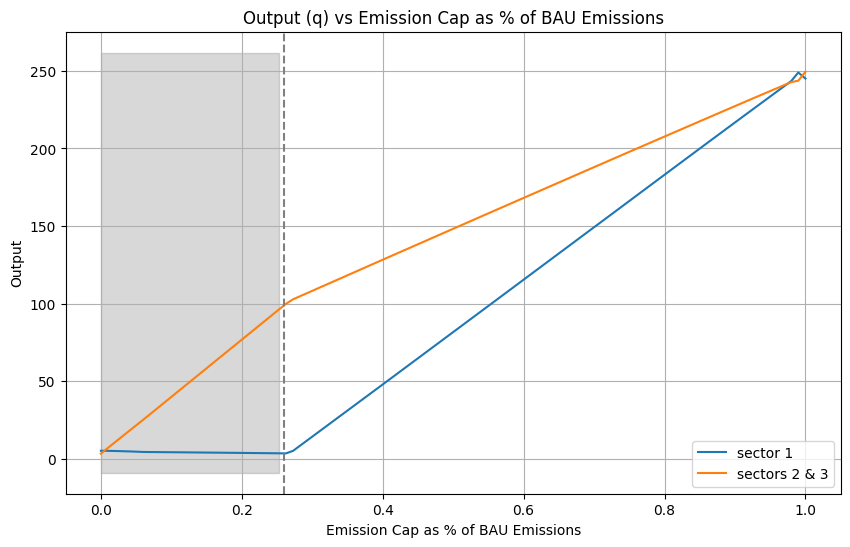

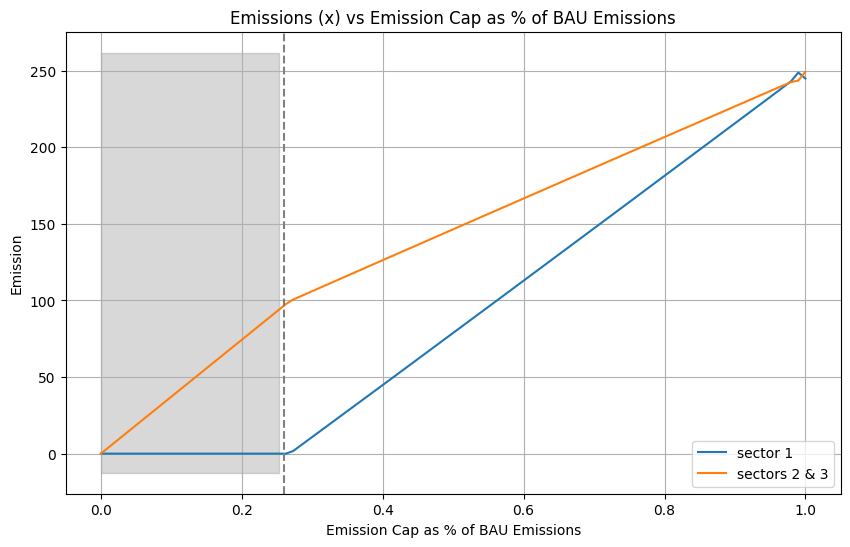

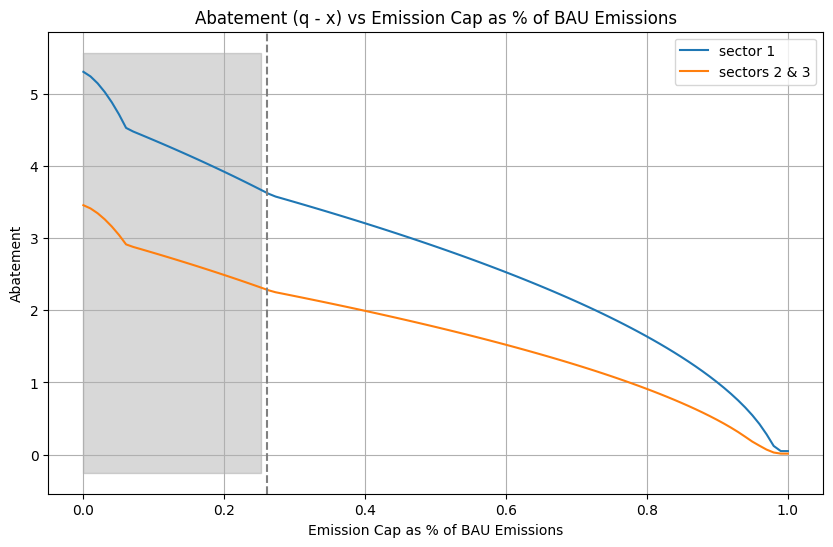

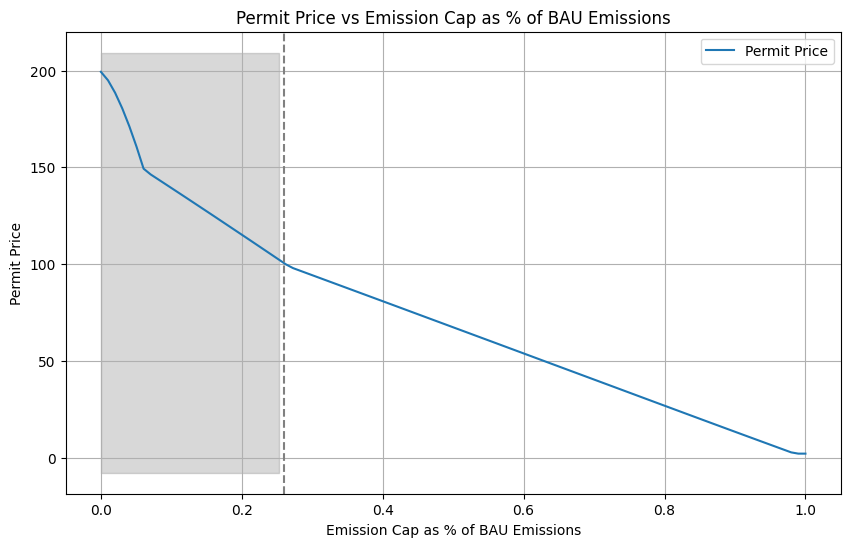

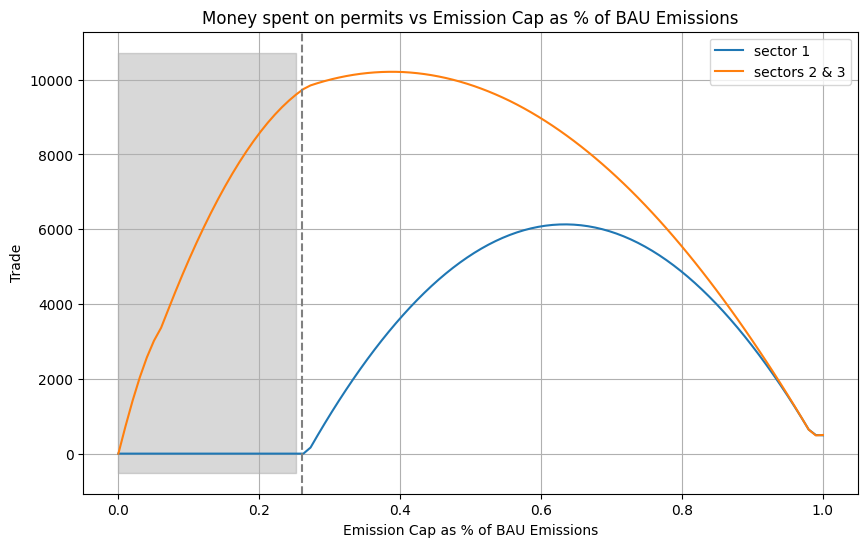

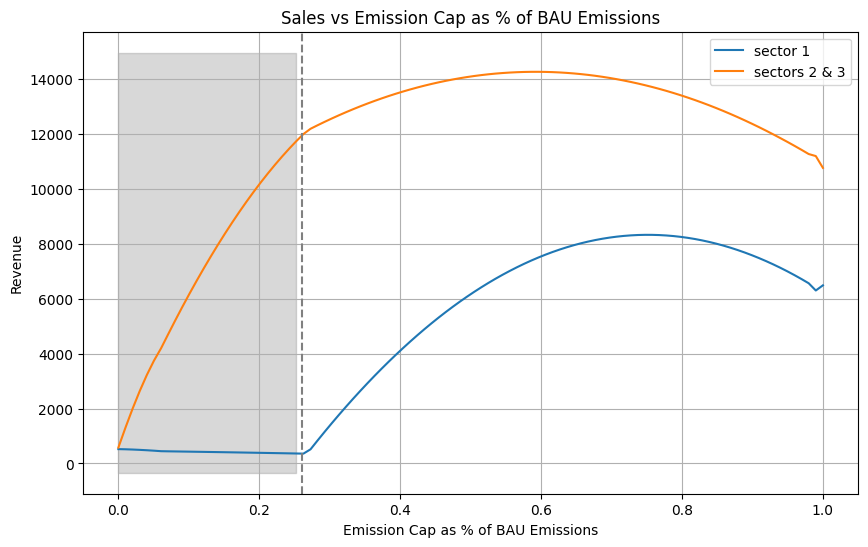

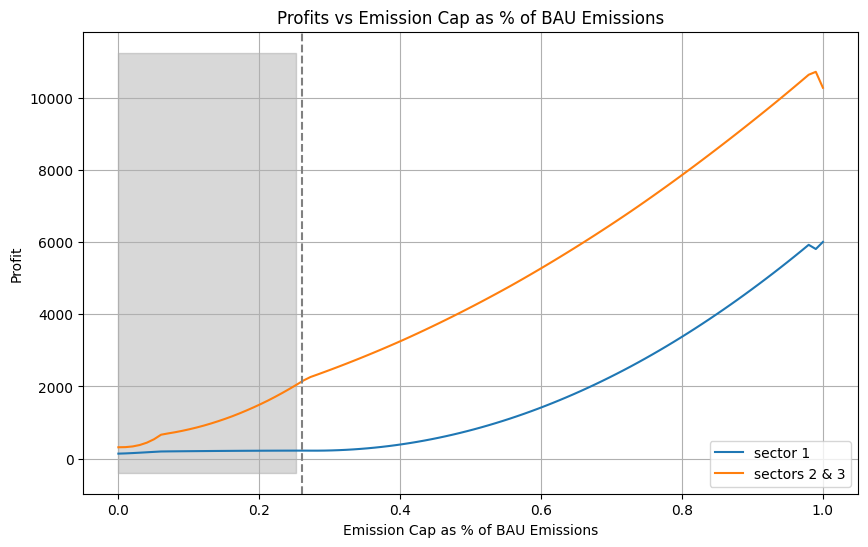

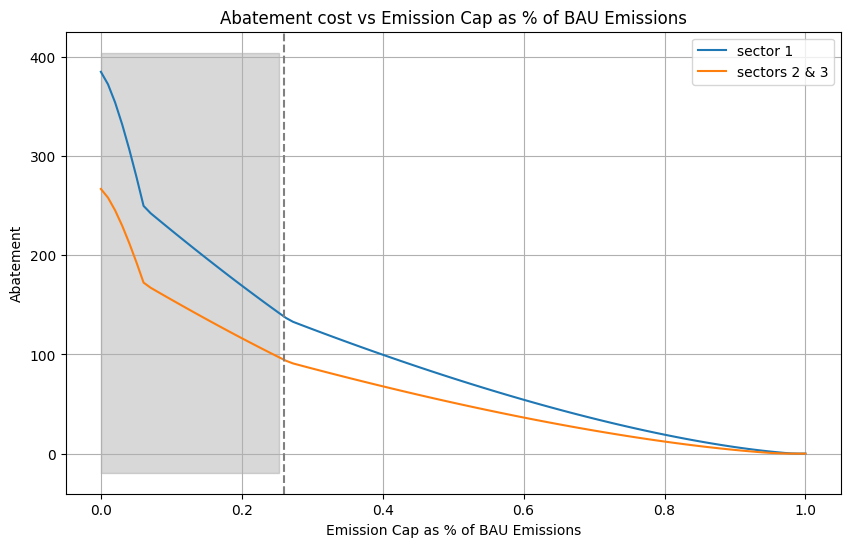

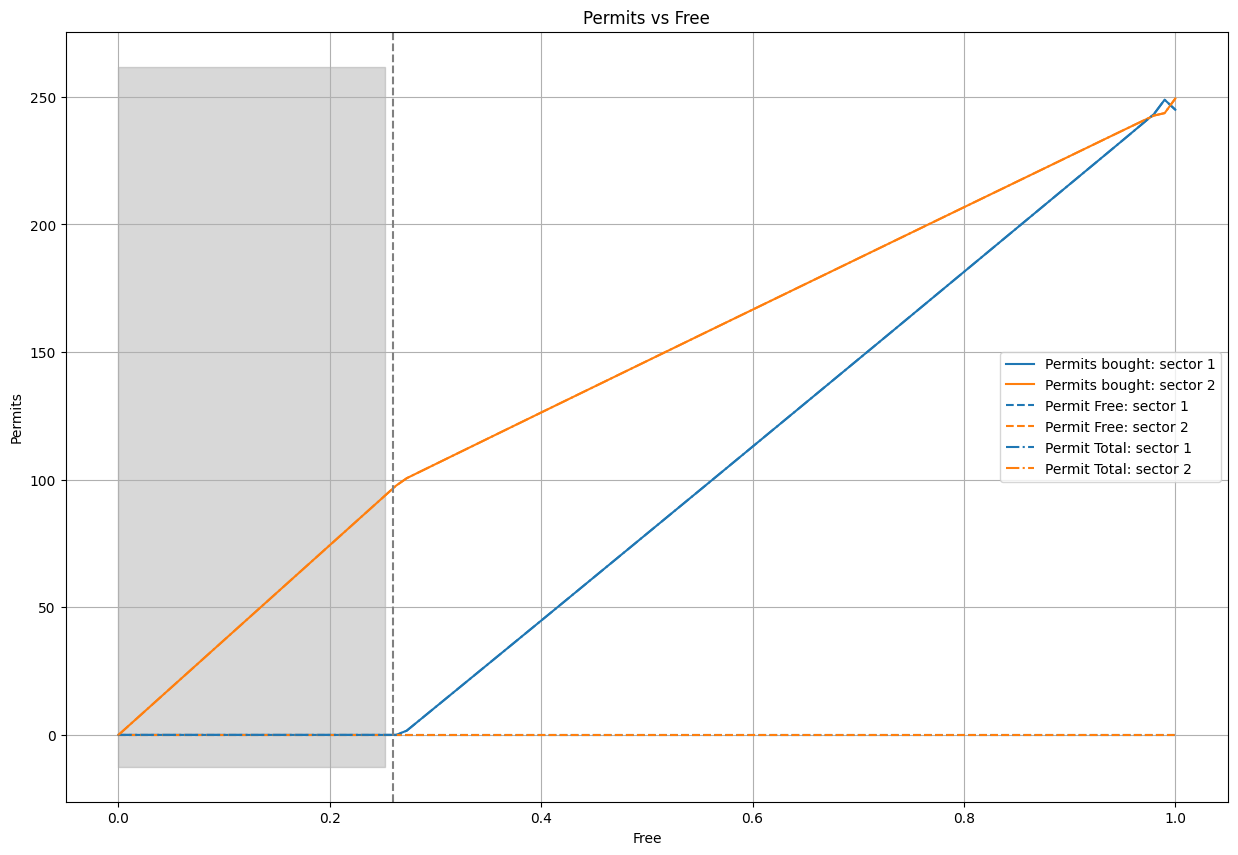

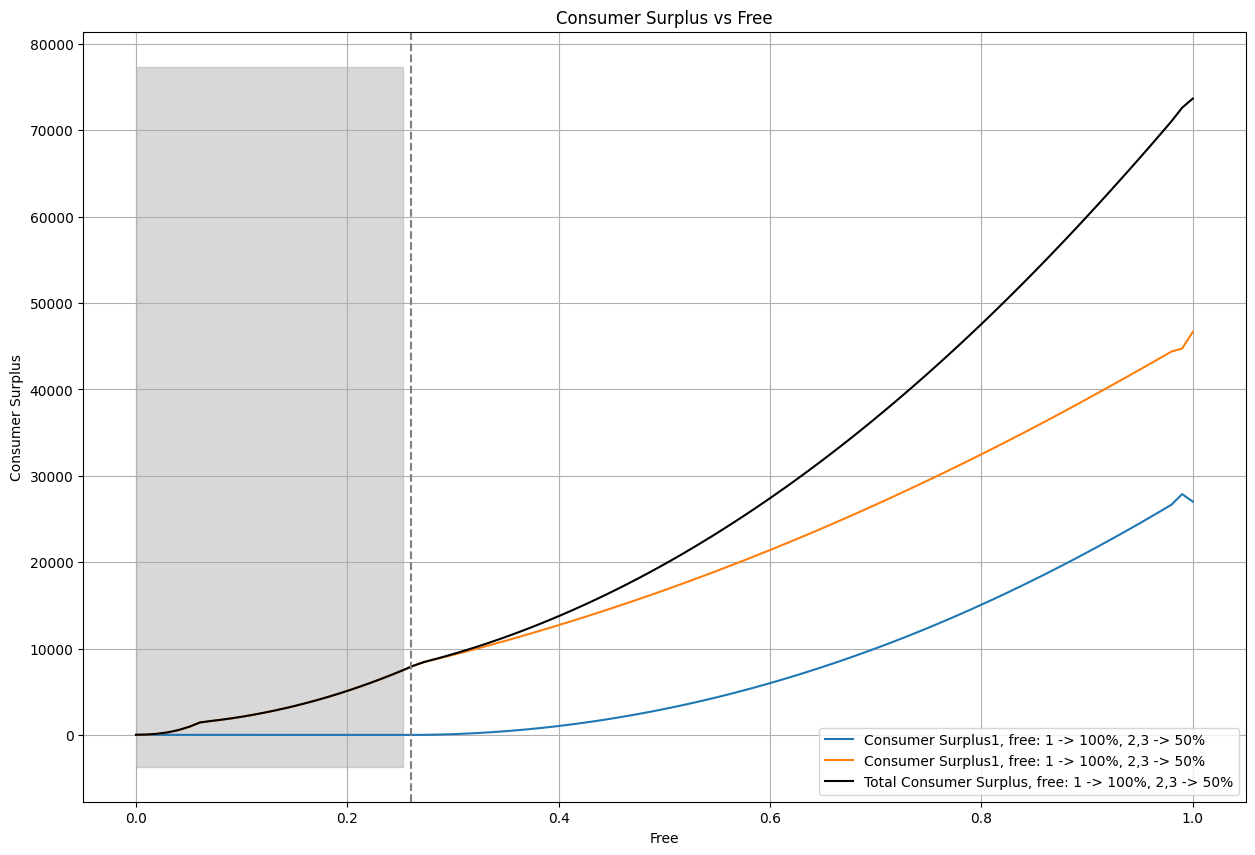

In [10]:
percentage_of_emission_cap = Regulator26.emission_cap / Regulator26.BAU_emissions
first_value = 0
last_value = 100
# Define colors
colors = {'trades1': '#1f77b4', 'trades2': '#ff7f0e'}

last_wrong_value = 0.26

# Define a function to plot the metrics
def plot_metric(metric, ylabel, title):
    plt.figure(figsize=(10, 6))
    plt.plot(frees, results[True][f'{metric}1'], label='sector 1', color=colors['trades1'])
    plt.plot(frees, results[True][f'{metric}2'], label='sectors 2 & 3', color=colors['trades2'])
    plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
    plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
    plt.xlabel('Emission Cap as % of BAU Emissions')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Plot outputs
plot_metric('outputs', 'Output', 'Output (q) vs Emission Cap as % of BAU Emissions')

# Plot emissions
plot_metric('emissions', 'Emission', 'Emissions (x) vs Emission Cap as % of BAU Emissions')

# Plot the difference output - emission to illustrate the abatement
plt.figure(figsize=(10, 6))
plt.plot(frees, np.array(results[True]['outputs1']) - np.array(results[True]['emissions1']), label='sector 1', color=colors['trades1'])
plt.plot(frees, np.array(results[True]['outputs2']) - np.array(results[True]['emissions2']), label='sectors 2 & 3', color=colors['trades2'])
plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
plt.xlabel('Emission Cap as % of BAU Emissions')
plt.ylabel('Abatement')
plt.title('Abatement (q - x) vs Emission Cap as % of BAU Emissions')
plt.legend()
plt.grid()
plt.show()

# Plot permit prices
plt.figure(figsize=(10, 6))
plt.plot(frees, results[True]['permit_price'], label='Permit Price', color=colors['trades1'])
plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
plt.xlabel('Emission Cap as % of BAU Emissions')
plt.ylabel('Permit Price')
plt.title('Permit Price vs Emission Cap as % of BAU Emissions')
plt.legend()
plt.grid()
plt.show()


# Plot trades
plot_metric('trades', 'Trade', 'Money spent on permits vs Emission Cap as % of BAU Emissions')

# Plot revenues
plot_metric('revenews', 'Revenue', 'Sales vs Emission Cap as % of BAU Emissions')

# Plot profits
plot_metric('profits', 'Profit', 'Profits vs Emission Cap as % of BAU Emissions')

# Plot abatements
plot_metric('abatements', 'Abatement', 'Abatement cost vs Emission Cap as % of BAU Emissions')


# Plot permits bought, free, and used for each doentage
alphas = {True: 1, False: 0.5}
colors = {'b': '#1f77b4', 'o': '#ff7f0e'}
plt.figure(figsize=(15, 10))
for do in [True]: plt.plot(frees[first_value:last_value], results[do]['permits_bought_1'][first_value:last_value], label=f'Permits bought: sector 1', color=colors['b'], alpha=alphas[do])
for do in [True]:plt.plot(frees[first_value:last_value], results[do]['permits_bought_2'][first_value:last_value], label=f'Permits bought: sector 2', color=colors['o'], alpha=alphas[do])
for do in [True]:plt.plot(frees[first_value:last_value], results[do]['permits_free_1'][first_value:last_value], label=f'Permit Free: sector 1', color=colors['b'], linestyle='--', alpha=alphas[do])
for do in [True]:plt.plot(frees[first_value:last_value], results[do]['permits_free_2'][first_value:last_value], label=f'Permit Free: sector 2', color=colors['o'], linestyle='--', alpha=alphas[do])
for do in [True]:plt.plot(frees[first_value:last_value], results[do]['permits_used_1'][first_value:last_value], label=f'Permit Total: sector 1', color=colors['b'], linestyle='-.', alpha=alphas[do])
for do in [True]:plt.plot(frees[first_value:last_value], results[do]['permits_used_2'][first_value:last_value], label=f'Permit Total: sector 2', color=colors['o'], linestyle='-.', alpha=alphas[do])
plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
plt.xlabel('Free')
plt.ylabel('Permits')
plt.title('Permits vs Free')
plt.legend()
plt.grid()
plt.show()



from operator import add
plt.figure(figsize=(15, 10))
plt.plot(frees[first_value:last_value], results[True]['consumer_surplus_1'][first_value:last_value], label=f'Consumer Surplus1, free: 1 -> 100%, 2,3 -> 50%', color=colors['b'])
plt.plot(frees[first_value:last_value], results[True]['consumer_surplus_2'][first_value:last_value], label=f'Consumer Surplus1, free: 1 -> 100%, 2,3 -> 50%', color=colors['o'])
plt.plot(frees[first_value:last_value], list( map(add,results[True]['consumer_surplus_1'], results[True]['consumer_surplus_2']))[first_value:last_value], label=f'Total Consumer Surplus, free: 1 -> 100%, 2,3 -> 50%', color='black')
plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
plt.xlabel('Free')
plt.ylabel('Consumer Surplus')
plt.title('Consumer Surplus vs Free')
plt.legend()
plt.grid()
plt.show()



In [12]:
for firm in Regulator26.firm_registry.values():
    print(firm.name, firm.free_permits, firm.permits_bought, firm.permits_used)
print(Regulator26.emission_cap, Regulator26.permit_price, Regulator26.BAU_emissions)

firm1 0.0 245.0 245.0
firm2 0.0 245.0 245.0
firm3 0.0 244.85450329184798 244.85450329184798
firm4 0.0 335.7395698692758 335.7395698692758
firm5 0.0 335.65944648472805 335.65944648472805
firm6 0.0 472.78129039217237 472.78129039217237
firm7 0.0 117.27203270927501 117.27203270927501
firm8 0.0 117.27203194488968 117.27203194488968
firm9 0.0 117.27203288422375 117.27203288422375
2230.8509075764127 2.0 2230.8509075764127
